## 2.5.2. Validating a linear regression model


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import math

In [2]:
path = ("/Users/gemma/Documents/data science/DS bootcamp/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv"
            )
df = pd.read_csv(path, delimiter= ',', encoding='latin-1',header=0)


In [3]:
# getting names of columns to access them more easily
# and renaming murder because the name is messy

colnames = df.columns.values
print(colnames)

# renamed it originally but later on wasn't necessary bc i dropped the columns
#df.rename({'Murder and\nnonnegligent\nmanslaughter' : 'Murder etc'}, axis='columns', inplace=True)


['City' 'Population' 'Violent\ncrime'
 'Murder and\nnonnegligent\nmanslaughter' 'Rape\n(revised\ndefinition)1'
 'Rape\n(legacy\ndefinition)2' 'Robbery' 'Aggravated\nassault'
 'Property\ncrime' 'Burglary' 'Larceny-\ntheft' 'Motor\nvehicle\ntheft'
 'Arson3']


In [4]:
df.head(3)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0


A glimpse at the data

In [5]:
# adding binary features - murder (or robbery) > 0 = 1, else 0

df['Murder bin'] = np.where(df[colnames[3]]==0, 0, 1)
df['Robbery bin'] = np.where(df['Robbery'] == 0, 0, 1)
df['Aggravated asault bin'] = np.where(df['Aggravated\nassault'] == 0,0,1)

In [6]:
# making the data frame i'll use for the regression

crime = df.drop(labels=colnames[2:8], axis=1)
crime.drop(labels=colnames[10:13], axis=1, inplace=True)

In [7]:
# renaming the weirdly named columns

crime.rename({'Murder bin': 'Murder', 'Robbery bin':'Robbery', 
              'Property\ncrime': 'Property crime', 'Aggravated asault bin': 'A. assault'}, axis='columns',inplace=True)


In [8]:
# cleaning up population and property crime 

num_cleanup = ['Population', 'Property crime','Burglary'] 

# there's at least one cell (in Population) with just a space, so filling blanks with NaN
crime = crime.replace(r'^\s*$', np.nan, regex=True)

# now dropping the row(s) that contain(s) the nan 
crime.dropna(axis=0, how='any', inplace=True)

# dropping commas and making integers

def cleanup(data_fr, numeric_str):
    # getting rid of commas
    data_fr[numeric_str] = data_fr[numeric_str].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

    # finally! the series is an integer (checked in the cell below)
    data_fr[numeric_str] = data_fr[numeric_str].astype(int)
    
    return

for one in num_cleanup:
    cleanup(crime, one)

# double checking
crime.dtypes


City              object
Population         int64
Property crime     int64
Burglary           int64
Murder             int64
Robbery            int64
A. assault         int64
dtype: object

Double checking the conversion of the columns to integers worked correctly

In [9]:
# adding pop ^2 bc i didnt do that yet

crime.insert(2, 'Popˆ2', crime['Population']**2, allow_duplicates=False)

In [10]:
crime.head(3)

,City,Population,Popˆ2,Property crime,Burglary,Murder,Robbery,A. assault
0,Adams Village,1861,3463321,12,2,0,1,1
1,Addison Town and Village,2577,6640929,24,3,0,1,1
2,Akron Village,2846,8099716,16,1,0,1,1


Added the feature "Population squared" as required for the initial formula

In [11]:
# holdout groups

data = crime[['Population','Popˆ2','Murder','Robbery','Burglary']]
target = crime['Property crime'] 

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)

regr = linear_model.LinearRegression()

print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: -432.9860601786066
Testing on Sample: 0.999576580943301


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Running the model with just the basic initial features, using 20% holdout. It looks like there might be overfitting due to the 99%% on the sample, and the strange holdout number.

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, data, target, cv=10)



array([   0.938554  ,    0.98519169,    0.84341985,    0.89958785,
          0.89559403,    0.93098549, -299.41182903,    0.99072378,
          0.99333016,    0.79445254])

Also tried to run cross validation with the same data, to see very mixed results.

In [13]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime['Property crime'].values.reshape(-1, 1)
X = crime[['Population','Popˆ2','Murder','Robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 3.42007759e-02 -2.05708444e-09 -9.55478272e+00  0.00000000e+00]]

Intercept: 
 [-156.63730133]

R-squared:
0.9960922903725817


Running the model to see the r squared and all of the coefficients

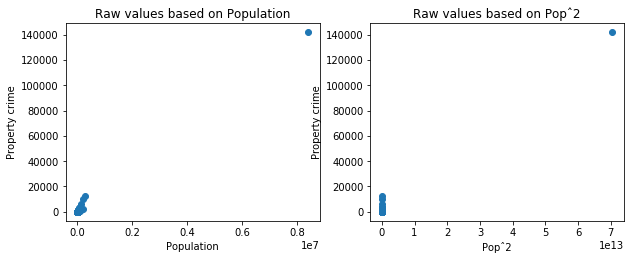

In [14]:
# checking if the data fits the assumtion of being linear...

labels = ['Population', 'Popˆ2']
Y = crime['Property crime'].values.reshape(-1, 1)

#,'Murder','Robbery']  #theyre binary so this is silly

plt.figure(figsize=(10,8))

for i, label in enumerate(labels):

    plt.subplot(2,2,i+1)
    plt.scatter(crime[label], Y)
    plt.xlabel(label)
    plt.ylabel('Property crime')
    plt.title('Raw values based on {}'.format(label))

plt.show()

Checking for linearity in the features of population and population squared compared to proprety crime.

From the plots, it looks like there is an outlier. I wanted to find what it was, in order to remove it from the model and prevent skewed data. Below, first i am finding the value of the outlier, and in the next cell, I am determining which city it is associated with. Finally, I am dropping it from the dataframe.

In [15]:
# looks like there's an outlier skewing the results

max(crime['Property crime'].unique().tolist())

141971

In [16]:
# finding where the outlier is

crime[crime['Property crime'] == 141971]

,City,Population,Popˆ2,Property crime,Burglary,Murder,Robbery,A. assault
216,New York,8396126,70494931807876,141971,16606,1,1,1


In [17]:
# dropping it

crime.drop([216], inplace=True)

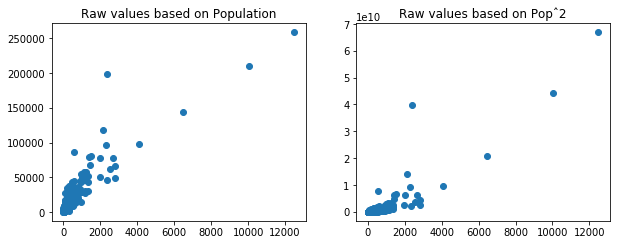

In [18]:
# to check again for linearity of data

plt.figure(figsize=(10,8))

for i, label in enumerate(labels):

    plt.subplot(2,2,i+1)
    plt.scatter(crime['Property crime'].values.reshape(-1, 1), crime[label])
    plt.title('Raw values based on {}'.format(label))

plt.show()

After removing the outlier, I checked the linearity again of these two features. It is much easier to see them without the outlier, and they look for the most part linear, although they could use a little improvement.

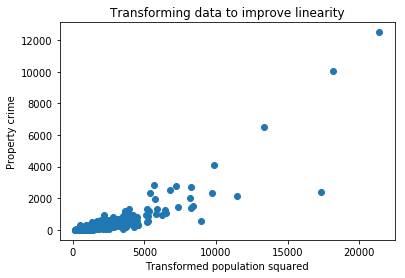

In [19]:
def myformula(value):
    return value**.4

crime['popˆ2 ftd'] = crime['Popˆ2'].apply(myformula)

plt.scatter(crime['popˆ2 ftd'],  crime['Property crime'].values.reshape(-1, 1))
plt.title('Transforming data to improve linearity')
plt.xlabel('Transformed population squared')
plt.ylabel('Property crime')
plt.show()

Above and below, I am trying different formulas to make the population and population squared more linear.

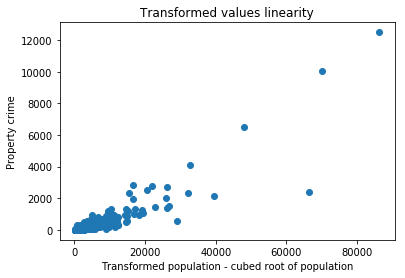

In [20]:
def my2ndform(value):
#    return 1/math.sqrt(math.log(value))
#    return math.sqrt(value**3)
    return value**1/3
    

crime['cube rt pop'] = crime['Population'].apply(my2ndform)

plt.scatter(crime['cube rt pop'],  crime['Property crime'].values.reshape(-1, 1))
plt.title('Transformed values linearity')
plt.xlabel('Transformed population - cubed root of population')
plt.ylabel('Property crime')
plt.show()

In [21]:
crime.head(4)

,City,Population,Popˆ2,Property crime,Burglary,Murder,Robbery,A. assault,popˆ2 ftd,cube rt pop
0,Adams Village,1861,3463321,12,2,0,1,1,412.854572,620.333333
1,Addison Town and Village,2577,6640929,24,3,0,1,1,535.662859,859.000000
2,Akron Village,2846,8099716,16,1,0,1,1,579.946480,948.666667
3,Albany,97956,9595377936,4090,705,1,1,1,9836.143001,32652.000000


Above, looking at the table with the transformed variables

In [22]:
# trying to figure out the error below
print(len(crime[['Population','popˆ2 ftd']]))

actual = crime['Property crime']

print(len(actual))

347
347


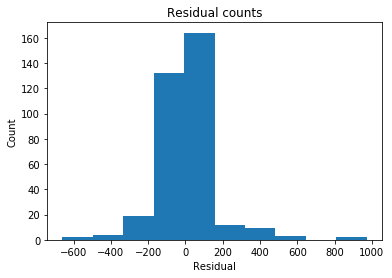

In [23]:

X4 = crime[['Population','popˆ2 ftd', 'Murder', 'Burglary', 'cube rt pop' ]]
actual2 = crime['Property crime']
#.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X4, actual)


# Extract predicted values.
predicted2 = regr.predict(X4).ravel()


# Calculate the error, also called the residual.
residual2 = actual2 - predicted2

# This looks a bit concerning.
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
#plt.ylim([-100, 100])
#plt.xlim([-7800,7800])
plt.show()

Reviewing the residual counts with the transformed data and the features that impact the model the most

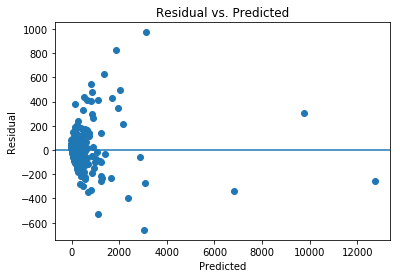

In [24]:
plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


Looking at the residual vs predicted values variance

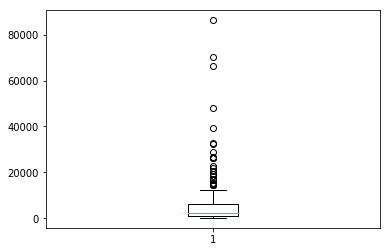

In [25]:
plt.boxplot(crime['cube rt pop'])
plt.show()

This is another look at the variance, paying attention to the outliers and the general range

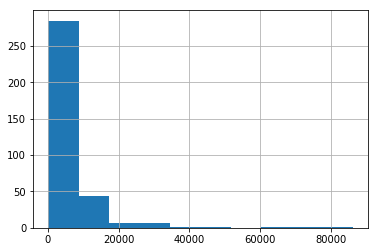

In [26]:
crime['cube rt pop'].hist()

A histogram of the transformed population variable

In [27]:
# w/ holdout groups
target2 = crime['Property crime']
data2 = crime[['cube rt pop','Popˆ2','popˆ2 ftd', 'Murder', 'Burglary', 'A. assault']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=20)

print('With 20% Holdout: ' + str(regr.fit(X_train2, y_train2).score(X_test2, y_test2)))
print('Testing on Sample: ' + str(regr.fit(data2, target2).score(data2, target2)))



With 20% Holdout: 0.9197121314124477
Testing on Sample: 0.9804961989284375


Trying the model with the improved features. It looks like it is much better, because the holdout % is much closer to the value on the test sample.

In [28]:
# cross val

cross_val_score(regr, data2,target2, cv=10)

array([0.95393861, 0.99146737, 0.88822266, 0.91530184, 0.8677339 ,
       0.90168402, 0.9169564 , 0.99073716, 0.9599027 , 0.85963183])

Also trying to cross validate the score. It also looks like the model is much improved over the original version.

In [29]:
regr = linear_model.LinearRegression()
Y3 = crime['Property crime'].values.reshape(-1, 1)
X3 = crime[['cube rt pop','Popˆ2','popˆ2 ftd','Murder','Robbery', 'A. assault','Burglary']]
regr.fit(X3, Y3)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X3, Y3))


Coefficients: 
 [[ 9.83344424e-02 -5.98089426e-08 -1.67175364e-01 -4.24672645e+01
   0.00000000e+00  0.00000000e+00  3.32451134e+00]]

Intercept: 
 [29.35433768]

R-squared:
0.9804961989284375


Above, the model is run in full again and shows the coefficients in addition to the r squared value and the intercept.

In [30]:
max(set(crime['Population'].tolist()))

258789/4

64697.25

Looking at the population values in order to improve the chart below, and see the data more clearly.

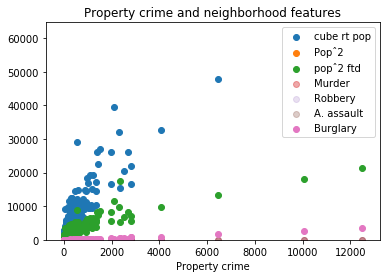

In [31]:
plt.scatter(crime['Property crime'], crime['cube rt pop'])
plt.scatter(crime['Property crime'], crime['Popˆ2'])
plt.scatter(crime['Property crime'], crime['popˆ2 ftd'])
plt.scatter(crime['Property crime'], crime['Murder'], alpha=0.4)
plt.scatter(crime['Property crime'], crime['Robbery'], alpha=0.2)
plt.scatter(crime['Property crime'], crime['A. assault'], alpha=0.3)
plt.scatter(crime['Property crime'], crime['Burglary'])
plt.legend()
plt.xlabel('Property crime')
plt.title('Property crime and neighborhood features')
plt.ylim([0,64697])
plt.show()


I wanted to look at the variance of the features and variables that I selected, to see which ones were most significant in the model. The population squared doesn't show up on this chart becasue I narrowed the y range too much, in order to get a better view of the other variables.

In [32]:
correlation_matrix = X3.corr()
display(correlation_matrix)


,cube rt pop,Popˆ2,popˆ2 ftd,Murder,Robbery,A. assault,Burglary
cube rt pop,1.000000,0.888582,0.989268,0.502713,NaN,NaN,0.819673
Popˆ2,0.888582,1.000000,0.817208,0.344873,NaN,NaN,0.892961
popˆ2 ftd,0.989268,0.817208,1.000000,0.529482,NaN,NaN,0.766474
Murder,0.502713,0.344873,0.529482,1.000000,NaN,NaN,0.401800
Robbery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A. assault,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Burglary,0.819673,0.892961,0.766474,0.401800,NaN,NaN,1.000000


Taking a look at the correlation matrix to get numeric vlaues for what's visible in the chart above. It looks like robbery and aggravated assault don't add anything significant to the model, whereas burglary does seem to be significant to the model, as well as the transofmred population variable, and murder.

However, at the same time, there is a very high correlation between cube rt pop, and popˆ2 ftd - 98.9%. It might be a good idea to just pick one of the two in order to avoid overlapping features.

# Validating the model above

In [33]:
# renaming the col so its 1 word

crime.rename({'Property crime' : 'Propertycrime', 'cube rt pop': 'cubeRTpop', 
             'A. assault' : 'A.assault', 'popˆ2 ftd': 'popˆ2ftd'}, axis='columns', inplace=True)


In [34]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [35]:
linear_formula = 'Propertycrime ~ cubeRTpop+Popˆ2+popˆ2ftd+Murder+Burglary'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=crime).fit()

print('Parameters \n\n{}'.format(lm.params))
print('\n\nP values \n\n{}'.format(lm.pvalues))
print('\nR Squared\n\n{}'.format(lm.rsquared))


Parameters 

Intercept    2.935434e+01
cubeRTpop    9.833444e-02
Popˆ2       -5.980894e-08
popˆ2ftd    -1.671754e-01
Murder      -4.246726e+01
Burglary     3.324511e+00
dtype: float64


P values 

Intercept     1.760355e-01
cubeRTpop     7.753926e-07
Popˆ2         1.910850e-09
popˆ2ftd      3.032815e-03
Murder        1.243738e-01
Burglary     5.998567e-156
dtype: float64

R Squared

0.9804961989284375


Looking at the coefficients of each parameter, the p values - which looks like they are all significant - and the r squared value.

In [36]:
lm.conf_int()

,0,1
Intercept,-1.322945e+01,7.193812e+01
cubeRTpop,5.992009e-02,1.367488e-01
Popˆ2,-7.886856e-08,-4.074932e-08
popˆ2ftd,-2.773047e-01,-5.704602e-02
Murder,-9.669156e+01,1.175703e+01
Burglary,3.190575e+00,3.458448e+00


Looking at the confidence intervals, Murder crosses 0, so it appears to have too much variance to be useful. I'll drop Murder and then run the statitiscal tests again to see if that improves the model.

In [37]:
# going to drop murder
# and also
# going to try it dropping cube rt pop 1x, then another time, dropping popˆ2 ft

linear_formula2 = 'Propertycrime ~ Popˆ2+popˆ2ftd+Burglary'

# Fit the model to our data using the formula.
lm2 = smf.ols(formula=linear_formula2, data=crime).fit()

print('Parameters \n\n{}'.format(lm2.params))
print('\n\nP values \n\n{}'.format(lm2.pvalues))
print('\nR Squared\n\n{}'.format(lm2.rsquared))

lm2.conf_int()

Parameters 

Intercept   -5.904076e+01
Popˆ2       -1.394893e-08
popˆ2ftd     1.093207e-01
Burglary     3.257088e+00
dtype: float64


P values 

Intercept     2.723105e-06
Popˆ2         5.527259e-04
popˆ2ftd      8.852594e-57
Burglary     9.847688e-153
dtype: float64

R Squared

0.9789351963161581


,0,1
Intercept,-8.338370e+01,-3.469781e+01
Popˆ2,-2.181789e-08,-6.079965e-09
popˆ2ftd,9.818905e-02,1.204524e-01
Burglary,3.122037e+00,3.392139e+00


Using the features pop ^2, popˆ2 ftd (the transformed popˆ2), and burglary, it looks like the r squared value dropped down to 97.89%, and also, when looking at the confidence intervals, the variance is greater for the popˆ2 ftd and popˆ2 when compared to the previous model.

In [38]:
# going to drop murder
# and also
# now for dropping popˆ2 ft

linear_formula3 = 'Propertycrime ~ cubeRTpop+Popˆ2+Burglary'

# Fit the model to our data using the formula.
lm3 = smf.ols(formula=linear_formula3, data=crime).fit()

print('Parameters \n\n{}'.format(lm3.params))
print('\n\nP values \n\n{}'.format(lm3.pvalues))
print('\nR Squared\n\n{}'.format(lm3.rsquared))

lm3.conf_int()

Parameters 

Intercept   -2.571851e+01
cubeRTpop    3.886825e-02
Popˆ2       -3.198701e-08
Burglary     3.273647e+00
dtype: float64


P values 

Intercept     1.825364e-02
cubeRTpop     4.645915e-60
Popˆ2         1.917243e-12
Burglary     1.671612e-156
dtype: float64

R Squared

0.9798404615320767


,0,1
Intercept,-4.704663e+01,-4.390383e+00
cubeRTpop,3.507072e-02,4.266578e-02
Popˆ2,-4.059588e-08,-2.337813e-08
Burglary,3.141795e+00,3.405498e+00


Using the features cube root of population, popˆ2, and burglary, the r squared value was lower than the original model, but slightly greater than the 2 second version, being 97.98% (compared to the last model's 97.89%). Also the variance in the confidence intervals is much smaller and shows greater accuracy of this model.

In [39]:
newone = ("/Users/gemma/Documents/data science/DS bootcamp/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.csv"
)

df2 = pd.read_csv(newone, delimiter= ',', encoding='latin-1',header=0)

df2.head(2)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,851",0,0.0,NaN,0.0,0,0,11,1,10,0,0.0
1,Addison Town and Village,"2,568",2,0.0,NaN,0.0,1,1,49,1,47,1,0.0


Looking at data from 2014 to test the model on a new dataset.
After loading the data (above), I'll add the transformations necessary to run the model (below).

In [40]:
colnames2 = df2.columns.values

# adding binary features - murder (or robbery) > 0 = 1, else 0

df2['Murder bin'] = np.where(df2[colnames2[3]]==0, 0, 1)

In [41]:
# renaming the weirdly named columns

df2.rename({'Property\ncrime': 'Propertycrime'}, axis='columns',inplace=True)


In [43]:
# cleaning up population and property crime 

num_cleanup2 = ['Population', 'Propertycrime','Burglary'] 

# filling blanks with 0
#df2 = df2.replace(r'^\s*$\n%' , 0, regex=True)

# now dropping the row(s) that contained the nan 
#df2.dropna(axis=0, how='any', inplace=True)

# dropping commas and making integers

def cleanup(data_fr, numeric_str):
    
    data_fr[numeric_str].replace(r'^\s*$\n% ', np.nan, regex=True)
#    data_fr[numeric_str].dropna(axis=0, how='any', inplace=True)
    
#    import  re
#    r = re.compile("\d+")
#    data_fr[numeric_str].apply(lambda x: int(r.search(x).group()))
    
    # getting rid of commas
    data_fr[numeric_str] = data_fr[numeric_str].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))
    
    data_fr[numeric_str] = data_fr[numeric_str].replace('', 0)
    data_fr[numeric_str].dropna(axis=0, how='any', inplace=True)
    # finally! the series is an integer (checked in the cell below)
    
    data_fr[numeric_str] = data_fr[numeric_str].astype(int)
    
    return

for one in num_cleanup2:
    cleanup(df2, one)

# double checking
df2.dtypes


City                                       object
Population                                  int64
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1               object
Rape\n(legacy\ndefinition)2               float64
Robbery                                    object
Aggravated\nassault                        object
Propertycrime                               int64
Burglary                                    int64
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
Murder bin                                  int64
dtype: object

Above, I was converting some of the columns to floats and integers. I printed out the dtypes to make sure the conversion was successful.

In [44]:
# adding the cubed root of population feature
df2['cubeRTpop'] = df2['Population'].apply(my2ndform)

#also adding pop ˆ2
df2.insert(2, 'Popˆ2', df2['Population']**2, allow_duplicates=False)

In [45]:
df2.head(3)

,City,Population,Popˆ2,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Propertycrime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder bin,cubeRTpop
0,Adams Village,1851,3426201,0,0.0,NaN,0.0,0,0,11,1,10,0,0.0,0,617.000000
1,Addison Town and Village,2568,6594624,2,0.0,NaN,0.0,1,1,49,1,47,1,0.0,0,856.000000
2,Afton Village4,820,672400,0,0.0,0,NaN,0,0,1,0,1,0,0.0,0,273.333333


Another look at the data with the new columns - cubed root of population and population squared

In [46]:
# w/ holdout groups
target_m2 = df2['Propertycrime']
data_m2 = df2[['cubeRTpop','Popˆ2', 'Burglary']]

X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(data_m2, target_m2, test_size=0.2, random_state=20)

print('With 20% Holdout: ' + str(regr.fit(X_train_m2, y_train_m2).score(X_test_m2, y_test_m2)))
print('Testing on Sample: ' + str(regr.fit(data_m2, target_m2).score(data_m2, target_m2)))



With 20% Holdout: -2.0033499590908983
Testing on Sample: 0.9995097514078446


Testing the model with 20% holdout on this new dataset. It looks like it continues to have a high r squared value.

In [47]:
lm4 = smf.ols(formula=linear_formula3, data=df2).fit()

print('Parameters \n\n{}'.format(lm4.params))
print('\n\nP values \n\n{}'.format(lm4.pvalues))
print('\nR Squared\n\n{}'.format(lm4.rsquared))

lm4.conf_int()

Parameters 

Intercept    2.859310e+00
cubeRTpop    2.733858e-02
Popˆ2        8.488870e-11
Burglary     3.293927e+00
dtype: float64


P values 

Intercept     7.678627e-01
cubeRTpop     3.636902e-48
Popˆ2         1.078361e-01
Burglary     4.141141e-173
dtype: float64

R Squared

0.9995097514078446


,0,1
Intercept,-1.617480e+01,2.189342e+01
cubeRTpop,2.416730e-02,3.050985e-02
Popˆ2,-1.866855e-11,1.884460e-10
Burglary,3.169703e+00,3.418151e+00


Here I used the original model to run the tests to show the coefficients for each feature, their p values, the r squared value, and the confidence intervals. It looks like population squared crosses 0 so I will drop that feature and re-test the model. 

Another reason I dropped population squared is because the correleation between population squared and cubed root of population was very high (above, there is a correlation matrix showing this), so only one of the two is necessary in the model.

In [48]:
linear_formula4 = 'Propertycrime ~ cubeRTpop+Burglary'

lm5 = smf.ols(formula=linear_formula4, data=df2).fit()

print('Parameters \n\n{}'.format(lm5.params))
print('\n\nP values \n\n{}'.format(lm5.pvalues))
print('\nR Squared\n\n{}'.format(lm5.rsquared))

lm5.conf_int()

Parameters 

Intercept   -5.409016
cubeRTpop    0.029905
Burglary     3.221343
dtype: float64


P values 

Intercept     5.112585e-01
cubeRTpop    1.751366e-294
Burglary     4.969449e-222
dtype: float64

R Squared

0.9995063273681382


,0,1
Intercept,-21.585175,10.767143
cubeRTpop,0.029397,0.030413
Burglary,3.134031,3.308655


Afer dropping population squared and reducing the model to 1 degree of freedom, the r squared value had no change, so it appears that the model is just as effective.

## a brief writeup of the reasoning behind the validation method you chose and the changes you made 

I looked at the p values of each feature in the model, as well as the confidence intervals, and tested it on multiple holdout groups as well as an entirely different dataset. When I saw that one feature crossed 0 in the confidence intervals, I dropped it and used features with a smaller range in their confidence intervals. Ultimately, the final version of the model consists of the cubed root of the population of the neighborhood, and the number of burglaries, in order to determine the number of property crimes.

